<a href="https://colab.research.google.com/github/mkbahk/AmazonBraket/blob/main/QuantumApplicationAlgorithm_VQA_VQE(PySCFOnly)_mkbahk_20251212.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pyscf==2.11.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 14.4 MB/s eta 0:00:00


In [18]:
#python3 3.12.12 버젼 필요
!python3 --version

Python 3.12.12


In [5]:
import numpy as np
from pyscf import gto, scf, mp, ci, cc

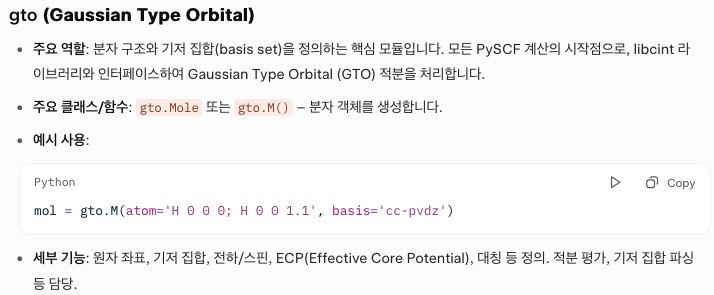

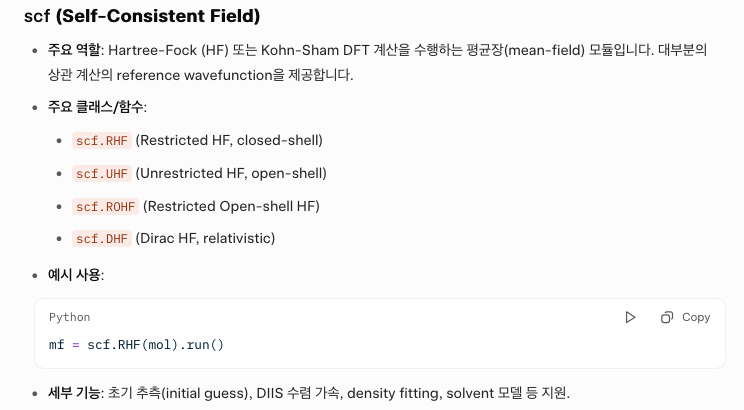

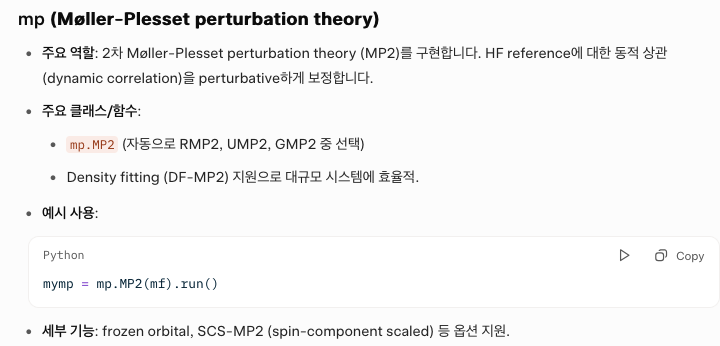

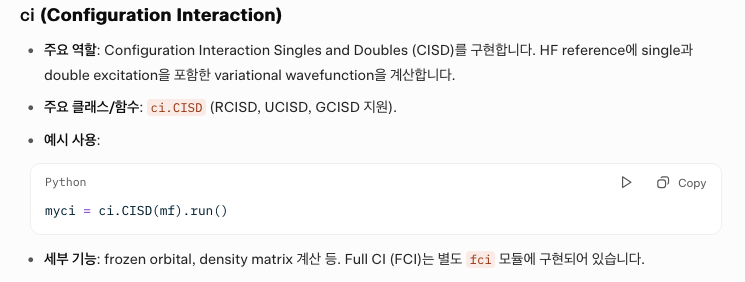

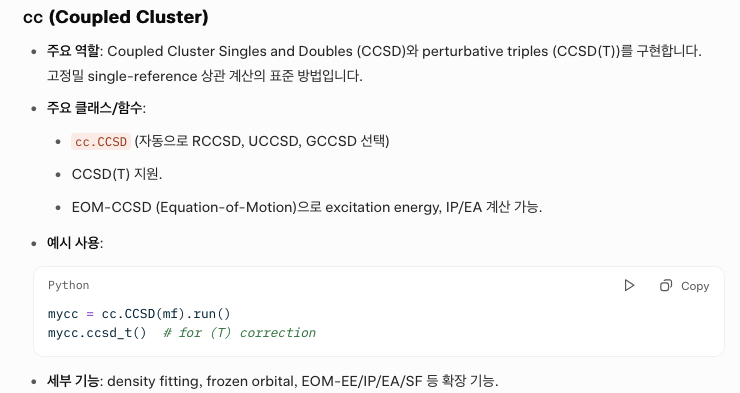

In [6]:
# 물분자 구조 정의 (단위: Angstrom)
mol = gto.Mole()

#물분자 구조
mol.atom = '''
    O  0.0000  0.0000  0.1173
    H  0.0000  0.7572 -0.4692
    H  0.0000 -0.7572 -0.4692
'''

#에탄올 (Ethanol, C₂H₅OH) – 탄소(C) + 수소(H) + 산소(O)
#3-종류 원소 (staggered conformation).

#mol.atom = """
#C   0.000000   0.000000   0.739000
#C   0.000000   0.000000  -0.811000
#O   0.000000   1.395000   1.139000
#H   0.000000  -0.951000   1.309000
#H   0.000000   0.951000   1.309000
#H   0.823000   0.000000  -1.381000
#H  -0.823000   0.000000  -1.381000
#H   0.000000   0.000000  -1.381000
#H   0.000000   1.395000   2.139000
#"""


#mol.basis = '6-31g'
mol.basis = 'sto-3g'
mol.unit = 'angstrom'
mol.spin = 0 # 435개의 전자는 홀수이므로 spin=0(단일항)과 일치하지 않습니다. spin=1(이중항)으로 설정합니다.
mol.build()

print("=" * 60)
print("계산용 분자 바닥상태 에너지 계산")
print("=" * 60)
print(f"기저 함수: {mol.basis}")
print(f"전자 수: {mol.nelectron}")
print(f"원자 수: {mol.natm}")
print("=" * 60)


계산용 분자 바닥상태 에너지 계산
기저 함수: sto-3g
전자 수: 10
원자 수: 3


In [7]:
#양자화학에서 전자 상관(electron correlation) 효과를 계산하는 방법들

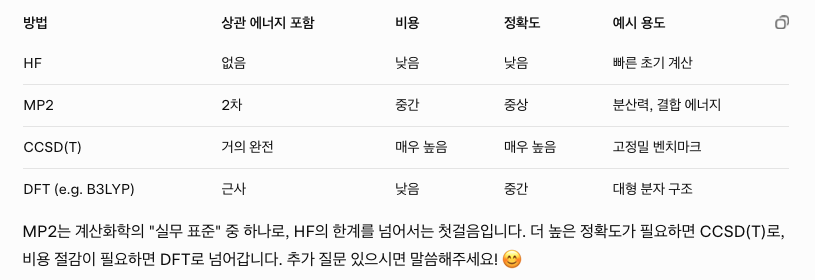

In [8]:
print("=" * 60)
print("계산용 분자 바닥상태 에너지 계산 방법들")
print("=" * 60)

#Hartree Fock
mf = scf.RHF(mol).run()  # HF reference
print("=" * 60)

# MP2
mp.MP2(mf).run()
print("=" * 60)

# CISD
ci.CISD(mf).run()
print("=" * 60)

# CCSD(T)
mycc = cc.CCSD(mf).run()
mycc.ccsd_t()
print("=" * 60)

계산용 분자 바닥상태 에너지 계산 방법들
converged SCF energy = -74.9630231384613
E(RMP2) = -74.9985687717234  E_corr = -0.0355456332621222
E(SCS-RMP2) = -75.0039187118203  E_corr = -0.0408955733590758
E(RCISD) = -75.01187316934733  E_corr = -0.04885003088605327
E(CCSD) = -75.01246171277273  E_corr = -0.04943857431146167
CCSD(T) correction = -6.74099258084082e-05


In [9]:
# 1. Hartree-Fock (HF) 계산
print("\n[1] Hartree-Fock (HF) 계산")  # 섹션 제목 출력 (단순히 콘솔에 표시용)

mf = scf.RHF(mol)  # Restricted Hartree-Fock 객체 생성
                   # - mol: 이전에 정의된 Mole 객체 (분자 구조 + basis set 등)
                   # - RHF: closed-shell 시스템(총 전자 수가 짝수, 스핀 0)에 적합한 제한된 HF 방법

mf.verbose = 4      #자세한 계산로그 출력

hf_energy = mf.kernel()  # 실제 SCF (Self-Consistent Field) 계산 실행
                         # - 반복적으로 Fock matrix를 구성하고 대각화하여 수렴할 때까지 최적화
                         # - 반환값: 총 전자 에너지 (nuclear repulsion energy는 별도 추가 필요 시 있음)

print("=" * 60)
print(f"HF 에너지: {hf_energy:.10f} Hartree")  # 계산된 에너지를 소수점 10자리까지 출력


[1] Hartree-Fock (HF) 계산


******** <class 'pyscf.scf.hf.RHF'> ********
method = RHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /tmp/tmpmg4wp_5y
max_memory 4000 MB (current use 181 MB)
Set gradient conv threshold to 3.16228e-05
Initial guess from minao.
init E= -74.8362481597436
  HOMO = -0.393121520338518  LUMO = 0.42642853693461
cycle= 1 E= -74.9128102141619  delta_E= -0.0766  |g|= 0.37  |ddm|= 1.69
  HOMO = -0.26769782534222  LUMO = 0.644096297569562
cycle= 2 E= -74.9624930055159  delta_E= -0.0497  |g|= 0.0425  |ddm|= 0.56
  HOMO = -0.390822358006007  LUMO = 0.604940139185049
cycle= 3 E= -74.9629968888871  delta_E= -0.000504  |g|= 0.00833  |ddm|= 0.0433
  HOMO = -0.391241087721668  LUMO = 0.605248670428921
cycle= 4 E= -74.9630231367246  delt

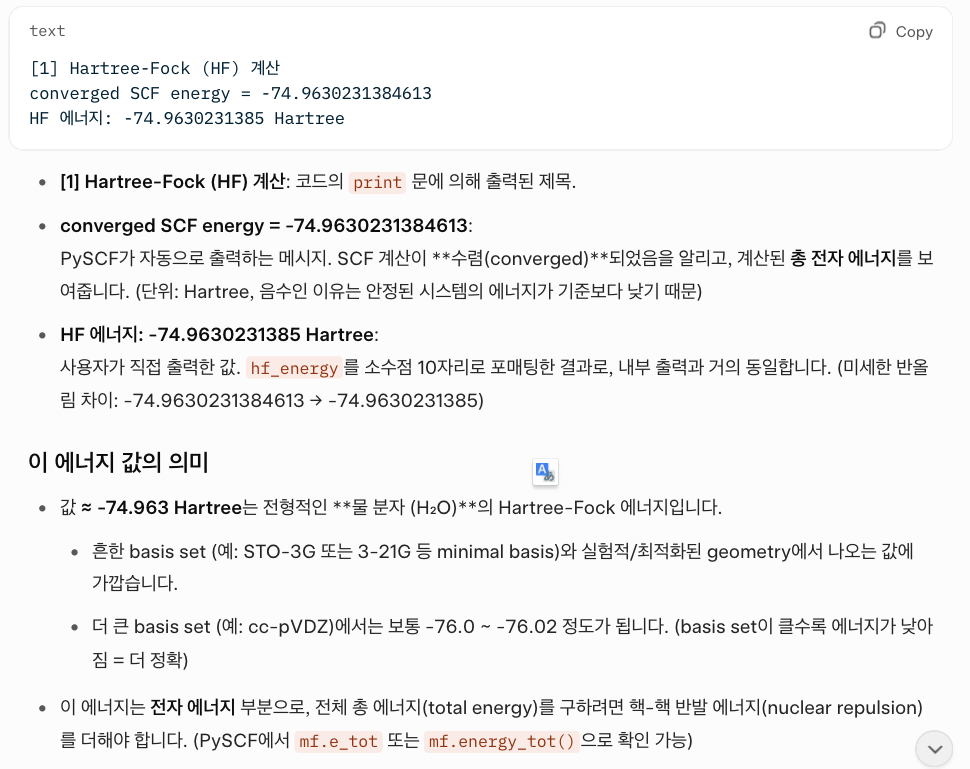

In [10]:
# 2. MP2 (Møller-Plesset 2차 섭동론) 계산
print("\n[2] MP2 계산")  # 섹션 제목 출력

mp2 = mp.MP2(mf)  # MP2 객체 생성
                  # - mf: 이전에 계산된 Hartree-Fock reference (RHF 객체)
                  # - PySCF는 closed-shell 시스템에 대해 Restricted MP2 (RMP2)를 자동 수행
mp2.verbose = 4
mp2_energy = mp2.kernel()[0]  # MP2 계산 실행 및 상관 에너지 추출
                              # - kernel()은 MP2 에너지 계산을 수행
                              # - 반환값: 튜플 (correlation energy, t2 amplitudes 등)
                              # - [0]: 상관 에너지 (correlation energy)만 가져옴

print(f"\n\nMP2 상관 에너지: {mp2_energy:.10f} Hartree")  # 상관 에너지 출력

print(f"MP2 총 에너지: {hf_energy + mp2_energy:.10f} Hartree")  # HF 에너지 + MP2 상관 에너지 = MP2 총 에너지


[2] MP2 계산

******** <class 'pyscf.mp.mp2.RMP2'> ********
nocc = 5, nmo = 7
max_memory 4000 MB (current use 184 MB)
E(RMP2) = -74.9985687717233  E_corr = -0.0355456332621242
E(SCS-RMP2) = -75.0039187118203  E_corr = -0.0408955733590781
E_corr(same-spin) = -0.00202983064092801
E_corr(oppo-spin) = -0.0335158026211962


MP2 상관 에너지: -0.0355456333 Hartree
MP2 총 에너지: -74.9985687717 Hartree


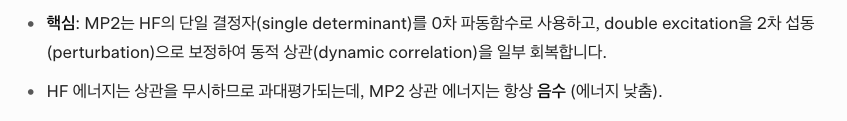

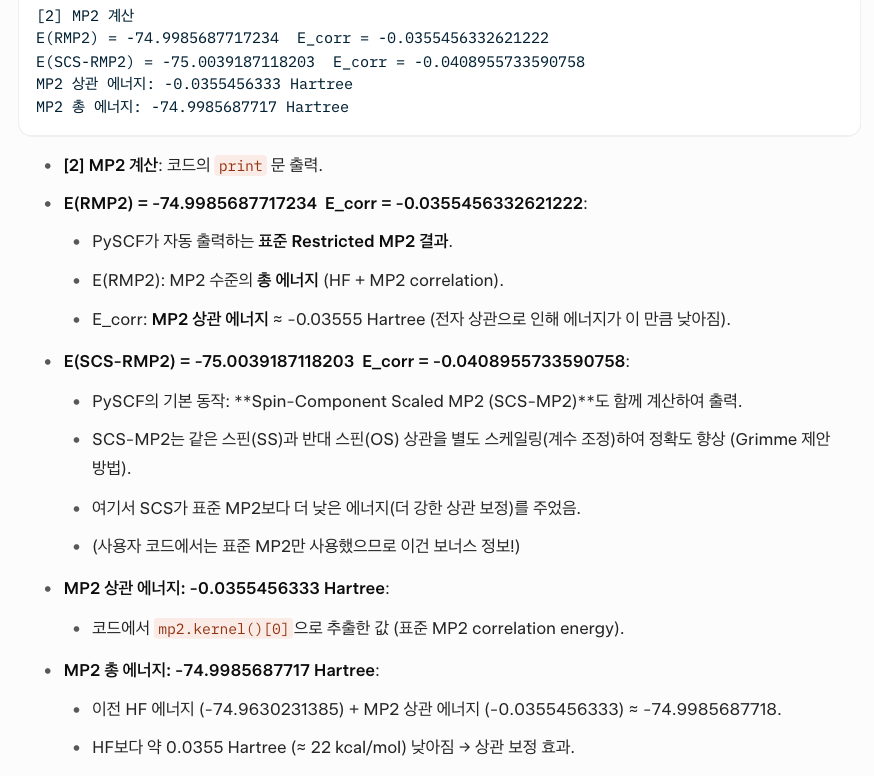

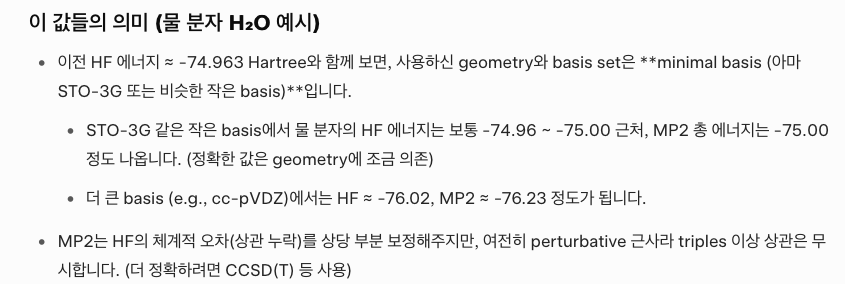

In [11]:
# 3. CCSD (Coupled Cluster Singles and Doubles) 계산
print("\n[3] CCSD 계산")  # 섹션 제목 출력

ccsd = cc.CCSD(mf)  # CCSD 객체 생성
                    # - mf: 이전에 수렴한 Hartree-Fock (RHF) reference
                    # - closed-shell 시스템에 대해 Restricted CCSD (RCCSD)를 자동 수행

ccsd.verbose = 5    # 상세 로그 출력 수준 설정
                    # - 0~5까지 있으며, 5는 가장 자세함 (iteration별 에너지, amplitude norm 등 출력)
                    # - 계산 과정 모니터링에 유용 (특히 수렴이 느릴 때)

ccsd_energy = ccsd.kernel()[0]  # CCSD 계산 실행 및 상관 에너지 추출
                                # - kernel(): CCSD 방정식을 반복적으로 풀어 수렴
                                # - 반환값: 튜플 (correlation energy, t1 amplitudes, t2 amplitudes)
                                # - [0]: CCSD 상관 에너지 (correlation energy)만 가져옴

print("=" * 60)  # 구분선 출력

print(f"CCSD 상관 에너지: {ccsd_energy:.10f} Hartree")  # 상관 에너지 출력

print(f"CCSD 총 에너지: {hf_energy + ccsd_energy:.10f} Hartree")  # HF 에너지 + CCSD 상관 에너지 = CCSD 총 에너지


[3] CCSD 계산

******** <class 'pyscf.cc.ccsd.CCSD'> ********
CC2 = 0
CCSD nocc = 5, nmo = 7
max_cycle = 50
direct = 0
conv_tol = 1e-07
conv_tol_normt = 1e-05
diis_space = 6
diis_start_cycle = 0
diis_start_energy_diff = 1e+09
max_memory 4000 MB (current use 184 MB)
    CPU time for CCSD integral transformation      0.03 sec, wall time      0.06 sec
Init t2, MP2 energy = -74.9985687701159  E_corr(MP2) -0.0355456316546393
    CPU time for init mp2      0.00 sec, wall time      0.00 sec
Init E_corr(CCSD) = -0.035545631655559
cycle = 1  E_corr(CCSD) = -0.0448982310396397  dE = -0.00935259938  norm(t1,t2) = 0.0288247
    CPU time for CCSD iter      0.05 sec, wall time      0.06 sec
cycle = 2  E_corr(CCSD) = -0.0477864548490182  dE = -0.00288822381  norm(t1,t2) = 0.0103975
    CPU time for CCSD iter      0.03 sec, wall time      0.02 sec
cycle = 3  E_corr(CCSD) = -0.0494304862898348  dE = -0.00164403144  norm(t1,t2) = 0.00422868
    CPU time for CCSD iter      0.04 sec, wall time      0.03 se

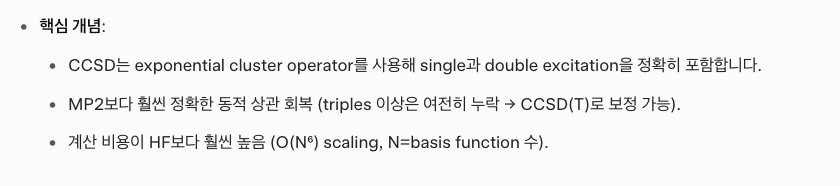

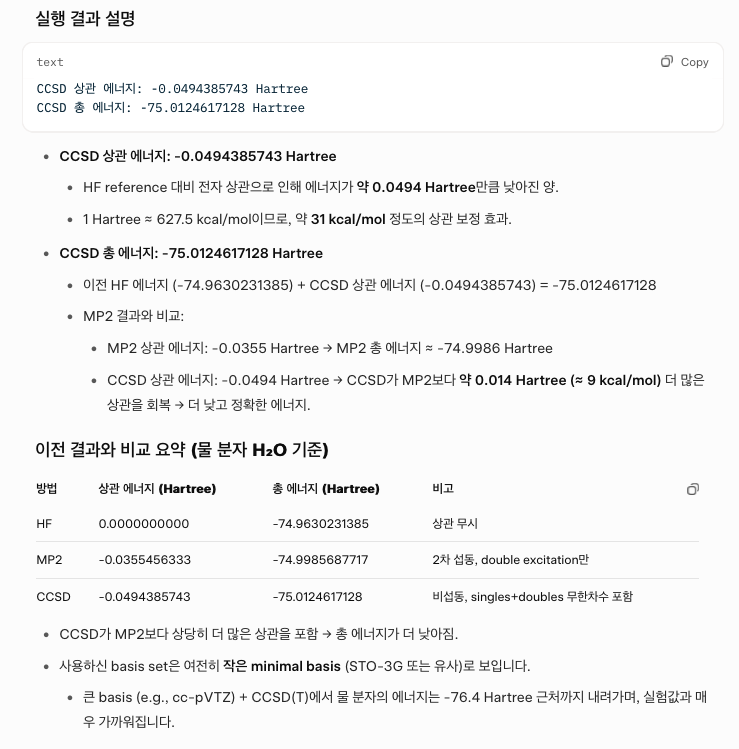

In [12]:
# 4. CISD (Configuration Interaction Singles and Doubles) 계산
print("\n[4] CISD 계산")
cisd = ci.CISD(mf)
cisd.verbose = 5
cisd_energy = cisd.kernel()[0]

print("=" * 60)  # 구분선 출력
print(f"CISD 상관 에너지: {cisd_energy:.10f} Hartree")
print(f"CISD 총 에너지: {hf_energy + cisd_energy:.10f} Hartree")


[4] CISD 계산
    CPU time for CCSD integral transformation      0.08 sec, wall time      0.09 sec

******** <class 'pyscf.ci.cisd.RCISD'> ********
CISD nocc = 5, nmo = 7
max_cycle = 50
direct = 0
conv_tol = 1e-09
max_cycle = 50
max_space = 12
lindep = 0
nroots = 1
max_memory 4000 MB (current use 184 MB)
Init t2, MP2 energy = -0.0355456316546393
davidson 0 1  |r|= 0.154  e= [-0.03612174]  max|de|= -0.0361  lindep= 0.548
davidson 1 2  |r|= 0.0556  e= [-0.04727138]  max|de|= -0.0111  lindep= 0.331
davidson 2 3  |r|= 0.0106  e= [-0.04878567]  max|de|= -0.00151  lindep= 0.795
davidson 3 4  |r|= 0.00244  e= [-0.04884694]  max|de|= -6.13e-05  lindep= 0.985
davidson 4 5  |r|= 0.00025  e= [-0.04885]  max|de|= -3.06e-06  lindep= 0.946
davidson 5 6  |r|= 2.99e-05  e= [-0.04885003]  max|de|= -3.36e-08  lindep= 0.975
root 0 converged  |r|= 3.93e-06  e= -0.048850030886053206  max|de|= -3.59e-10
converged 6 7  |r|= 3.93e-06  e= [-0.04885003]  max|de|= -3.59e-10
RCISD converged
E(RCISD) = -75.01187316

In [13]:
# Numpy를 이용한 에너지 비교 및 분석
print("\n" + "=" * 60)
print("에너지 비교 및 분석 (Numpy 사용)")
print("=" * 60)

# 에너지 값을 배열로 저장
methods = np.array(['HF', 'MP2', 'CCSD', 'CISD'])
energies = np.array([
    hf_energy,
    hf_energy + mp2_energy,
    hf_energy + ccsd_energy,
    hf_energy + cisd_energy
])

# HF 에너지를 기준으로 한 상대 에너지 (kcal/mol)
hartree_to_kcal = 627.509474  # 변환 계수
relative_energies = (energies - energies[0]) * hartree_to_kcal

print("\n총 에너지 비교:")
for i, method in enumerate(methods):
    print(f"{method:6s}: {energies[i]:15.10f} Hartree")
###for

print("\n상대 에너지 (HF 기준, kcal/mol):")
for i, method in enumerate(methods):
    print(f"{method:6s}: {relative_energies[i]:10.4f} kcal/mol")
###for



에너지 비교 및 분석 (Numpy 사용)

총 에너지 비교:
HF    :  -74.9630231385 Hartree
MP2   :  -74.9985687717 Hartree
CCSD  :  -75.0124617128 Hartree
CISD  :  -75.0118731693 Hartree

상대 에너지 (HF 기준, kcal/mol):
HF    :     0.0000 kcal/mol
MP2   :   -22.3052 kcal/mol
CCSD  :   -31.0232 kcal/mol
CISD  :   -30.6539 kcal/mol


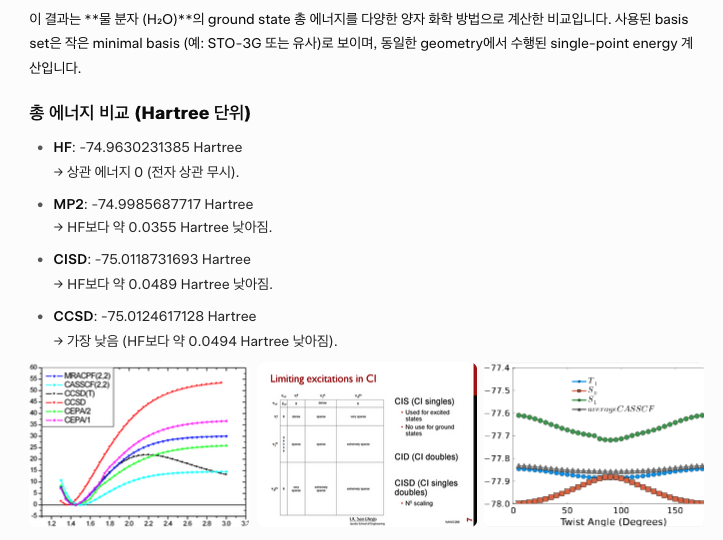

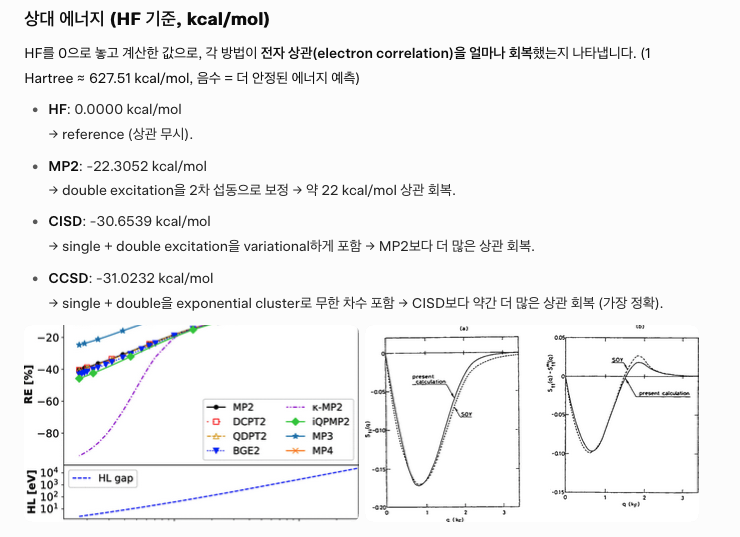

: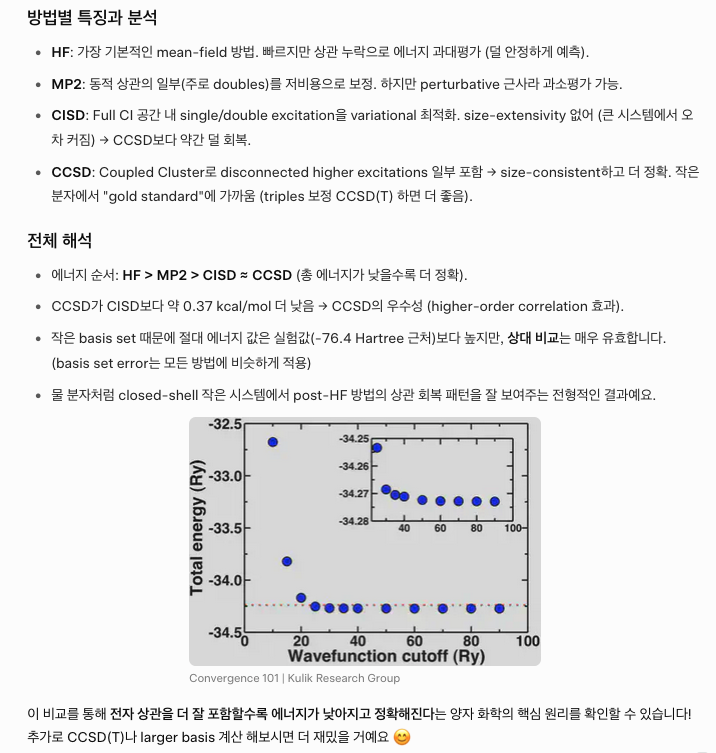

In [14]:
# 통계 분석
print("\n통계 분석 (Numpy):")
print(f"평균 에너지: {np.mean(energies):.10f} Hartree")
print(f"표준편차: {np.std(energies):.10f} Hartree")
print(f"최소 에너지: {np.min(energies):.10f} Hartree ({methods[np.argmin(energies)]})")
print(f"최대 에너지: {np.max(energies):.10f} Hartree ({methods[np.argmax(energies)]})")


통계 분석 (Numpy):
평균 에너지: -74.9964816981 Hartree
표준편차: 0.0201003069 Hartree
최소 에너지: -75.0124617128 Hartree (CCSD)
최대 에너지: -74.9630231385 Hartree (HF)


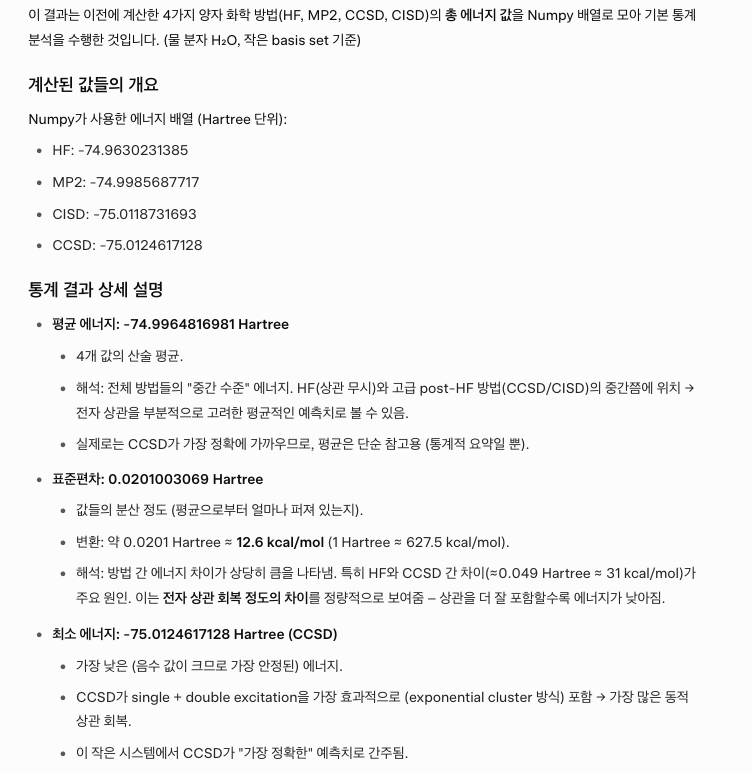

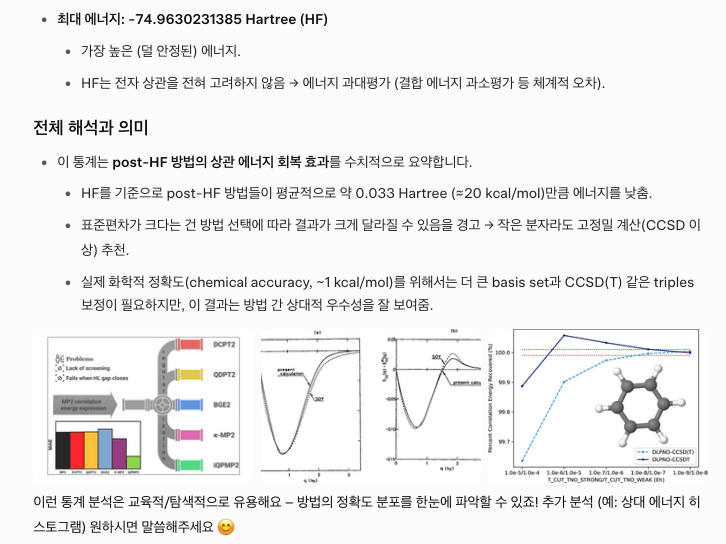

In [15]:
# 상관 에너지 비교
correlation_energies = np.array([0, mp2_energy, ccsd_energy, cisd_energy])
print("\n상관 에너지 회복률 (MP2 대비):")
for i in range(1, len(methods)):
    if i == 1:
        print(f"{methods[i]:6s}: 100.00% (기준)")
    else:
        recovery = (correlation_energies[i] / mp2_energy) * 100
        print(f"{methods[i]:6s}: {recovery:6.2f}%")
    ###if
###for


상관 에너지 회복률 (MP2 대비):
MP2   : 100.00% (기준)
CCSD  : 139.08%
CISD  : 137.43%


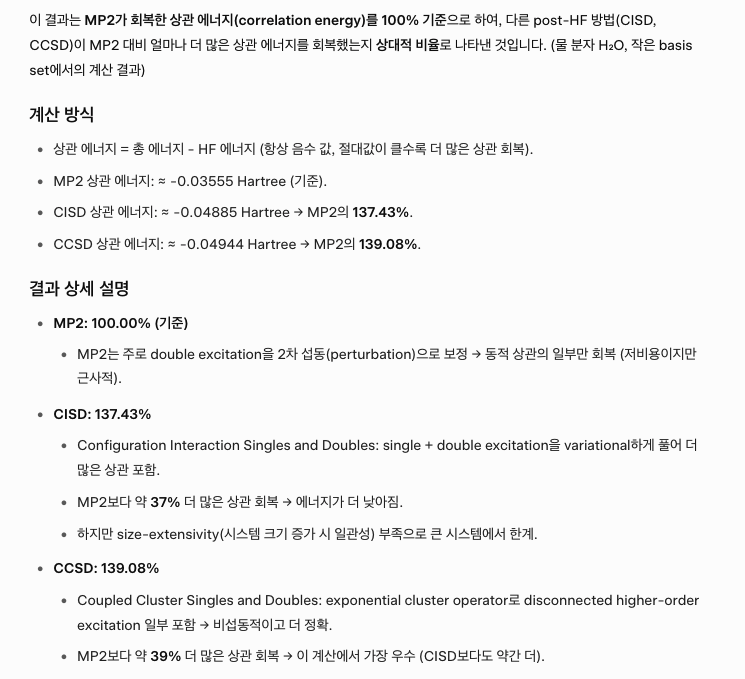

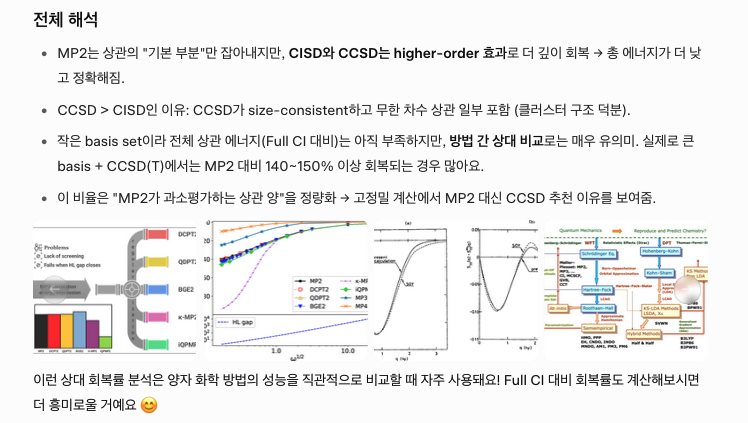

In [16]:
# 에너지 차이 행렬 (kcal/mol)
print("\n에너지 차이 행렬 (kcal/mol):")
print("       ", "".join([f"{m:>10s}" for m in methods]))
energy_diff_matrix = np.zeros((len(energies), len(energies)))
for i in range(len(energies)):
    diff_str = f"{methods[i]:6s} "
    for j in range(len(energies)):
        energy_diff_matrix[i, j] = (energies[i] - energies[j]) * hartree_to_kcal
        diff_str += f"{energy_diff_matrix[i, j]:10.4f}"
    ###for
    print(diff_str)
###for

print("\n" + "=" * 60)
print("계산 완료!")
print("=" * 60)


에너지 차이 행렬 (kcal/mol):
                HF       MP2      CCSD      CISD
HF         0.0000   22.3052   31.0232   30.6539
MP2      -22.3052    0.0000    8.7180    8.3486
CCSD     -31.0232   -8.7180    0.0000   -0.3693
CISD     -30.6539   -8.3486    0.3693    0.0000

계산 완료!


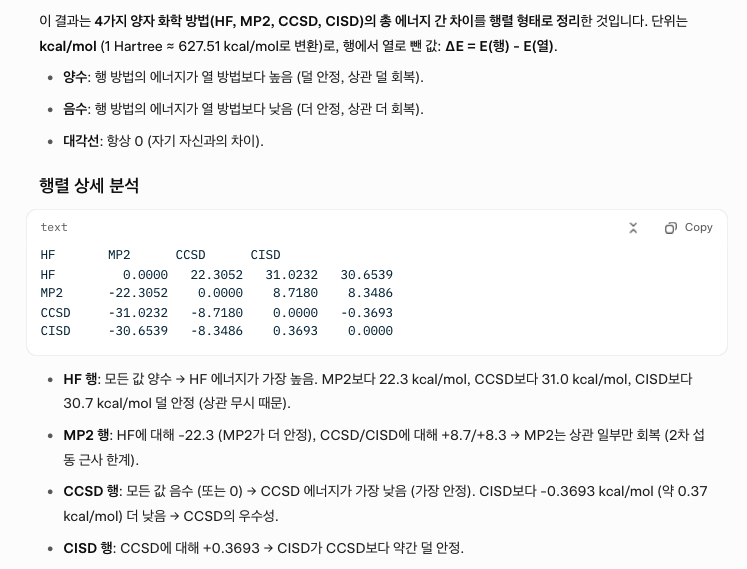

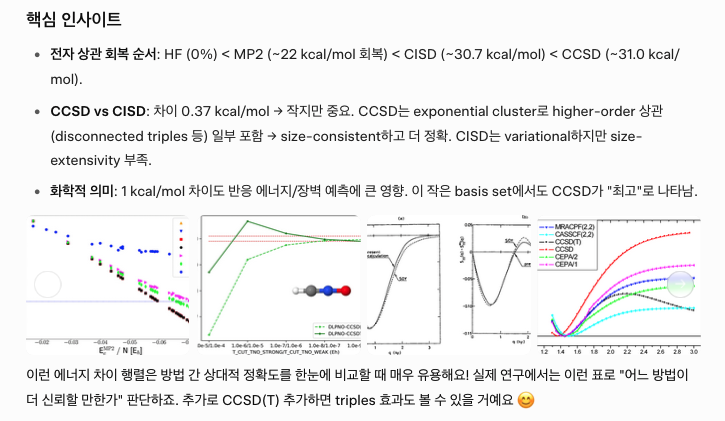